In [1]:
import os
import codecs
import numpy as np
import pandas as pd
import re
import string
from scipy import sparse
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import itertools
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from wordcloud import WordCloud
import tweepy
from tweepy import OAuthHandler,AppAuthHandler, Cursor
import json



%matplotlib inline  





/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Initialize the twitter API

In [2]:
consumer_key = 'your consumer_key'
consumer_secret = 'your consumer_secret'

access_token = 'your access_token'
access_secret = 'your access_secret'


auth = AppAuthHandler(consumer_key,consumer_secret)
#Making wait_on_rate_limit TRUE, so that the code will wait and continue when limit is reached.
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

#Making sure Authorization was obtained.
if (not api):
    print ("Can't Authorize.")
    sys.exit(-1)

### Preprocessing  the tweets, cleaning, tokenizing, removing the stop words 


In [3]:

def normalize_text(s):
    s = s.encode('ascii',errors='ignore')
    s = str(s.encode("utf-8").strip())
    s = s.lower()    
    # remove punctuation that is not word-internal (not in [a-zA-Z0-9_])
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W\s',' ',s)    
    # remove double space
    s = re.sub('\s+',' ',s)
    
    return s




def tweet_cleaner(tweet):
    tweet = tweet.lower()   
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)    
    
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    
    #Replace # with HASH_TAG
    tweet = re.sub('#', 'HASH_TAG ', tweet)
    
    #Temporarily store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', tweet)
    
    #Remove all non-word charactersand add the emoticons to 
    # the end of the processed document string
    # remove emoticon nose to be consistent
    tweet = re.sub('[\W]+', ' ', tweet) + ' ' + \
            ' '.join(emoticons).replace('-', '')
    
    #trim
    tweet = tweet.strip('\'"')
    return tweet


# Remove stop words and tokenize tweet, No stemming
def simple_tokenizer(tweet):
    tweet = tweet_cleaner(tweet)
    tw = [w for w in tweet.split() if w not in stop]
    return tw

# Tokenize stemmed words
def porter_tokenizer(tweet):
    tweet = tweet_cleaner(tweet)
    tw = [porter.stem(w) for w in tweet.split() if w not in stop]
    return tw

# Count the number of stop words in tweet
def count_stop(text):
    return len([w for w in text.lower().split() if w in stop ])

# Count the number of words in tweet
def no_of_word(text):
    return len(text.split())

# Calculate the ratio of Upper case letters in tweet
def upper(text):
    l = len(filter(lambda x: x in string.uppercase, text)) + len(filter(lambda x: x in string.lowercase, text))
    return float(len(filter(lambda x: x in string.uppercase, text)))/l
         
    
    





### Reading the data and some data exploration

In [4]:
porter = PorterStemmer()
stop = stopwords.words('english')


# This data set has around 20K tweets which labeled as organization, male and female by humans. Since there is no 
#information about the genders and people should guess the gender based on name and profile picture, there is also 
# confidence_level for genders.


tw_df = pd.read_csv("gender-classifier-DFE-791531.csv", encoding='latin1')
tw_df = tw_df[['_unit_id','gender','gender:confidence','text']]
tw_df.head()





,_unit_id,gender,gender:confidence,text
0,815719226,male,1.0000,Robbie E Responds To Critics After Win Against...
1,815719227,male,1.0000,ÛÏIt felt like they were my friends and I was...
2,815719228,male,0.6625,i absolutely adore when louis starts the songs...
3,815719229,male,1.0000,Hi @JordanSpieth - Looking at the url - do you...
4,815719230,female,1.0000,Watching Neighbours on Sky+ catching up with t...


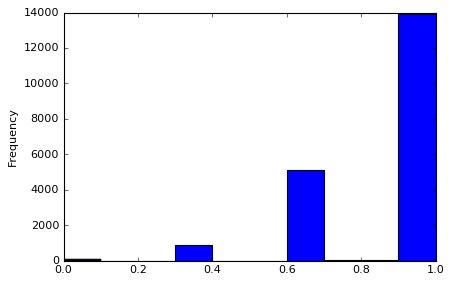

In [5]:
# genders' confidence level distribution

gend_conf = tw_df['gender:confidence'].plot(kind='hist', bins = 10)
plt.show()



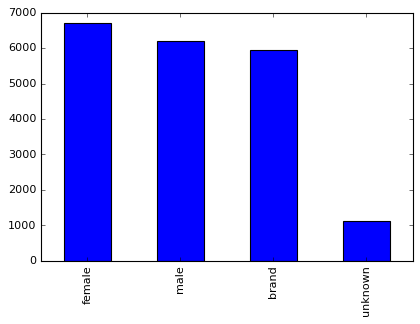

In [6]:
lable_count = tw_df.gender.value_counts().plot(kind='bar')

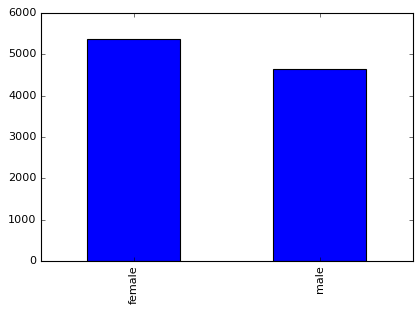

In [7]:
# Only tweets with the lable of female/male and confidence level > .9 are considered
tw_df = tw_df[tw_df['gender:confidence']>.9]
tw_df = tw_df[(tw_df['gender']=='female') |(tw_df['gender']=='male')]
gend_count = tw_df.gender.value_counts().plot(kind='bar')



In [8]:
tw_df['text_norm'] = tw_df['text'].apply(normalize_text)
tw_df['cleanTweet'] = tw_df['text'].apply(tweet_cleaner)

sid = SIA()
# add sentiment analysis to data
tw_df['pol'] = tw_df['text'].apply(lambda x:sid.polarity_scores(x)['compound'])
tw_df['words'] = tw_df['text'].apply(no_of_word)



In [9]:
print len(tw_df)
print tw_df.gender.value_counts()
# The data set is almost balanced

10023
female    5368
male      4655
Name: gender, dtype: int64


### Divide the data into the train set and the test set (80%-20%)

In [10]:
train = tw_df.sample(frac=0.80,random_state=200)
test = tw_df.drop(train.index)

encoder = LabelEncoder()
y = encoder.fit_transform(tw_df['gender'])


X_train = train.text.values
y_train = encoder.fit_transform(train.gender.values)
X_test = test.text.values
y_test = encoder.transform(test.gender.values)

### Make a pipeline for GridSearch to find the best parameters

In [25]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=True, preprocessor=None, max_features = 8000)
param_grid = [
    {'vect__ngram_range': [(1,1),(1,2)],
     'vect__tokenizer': [porter_tokenizer, simple_tokenizer],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': [1.0, 10.0, 50.0, 100.0]}
] 

lr_tfidf = Pipeline([ ('vect', tfidf), ('clf', LogisticRegression(random_state=0)) ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy',
                           cv=5, verbose=0, n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)
print(gs_lr_tfidf.best_params_)
print(gs_lr_tfidf.best_score_)

{'vect__ngram_range': (1, 2), 'vect__tokenizer': <function simple_tokenizer at 0x110b95488>, 'clf__penalty': 'l2', 'clf__C': 1.0}
0.618608131704


In [15]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.634


### Build the NLP model based on the best parameters & GridSearch for best "c" parameters for logistic regression

In [16]:
TF = TfidfVectorizer(strip_accents=None, lowercase=True, preprocessor=None, 
                     tokenizer = porter_tokenizer,stop_words = None, ngram_range = (1,1),use_idf = True)
lg_cv = LogisticRegressionCV(Cs=[x for x in np.arange(.1,2,.4) ], cv=5, class_weight='balanced', n_jobs=-1)


In [17]:
X_tfidf = TF.fit_transform(X_train)
X_other = train[['pol','words']]
# add snetiment analysis and number of words as feature
X = sparse.hstack([X_tfidf, X_other])

In [18]:
lg_cv.fit(X, y_train)
print(lg_cv.scores_)
print(lg_cv.score(X, y_train))
print(lg_cv.C_)

{1: array([[ 0.63029925,  0.64339152,  0.6340399 ,  0.63029925,  0.62718204],
       [ 0.58541147,  0.6084788 ,  0.59975062,  0.59476309,  0.58665835],
       [ 0.60286783,  0.61533666,  0.61471322,  0.60785536,  0.60349127],
       [ 0.58702433,  0.61509669,  0.61197754,  0.60449158,  0.60262009],
       [ 0.60948222,  0.62258266,  0.62694947,  0.63069245,  0.6338116 ]])}
0.779496133699
[ 0.5]


In [32]:
lg_clf = LogisticRegression(C = 0.5)

In [33]:
lg_clf.fit(X, y_train)
test_other = test[['pol','words']]
test_tf = TF.transform(X_test)
Xtest = sparse.hstack([test_tf, test_other])
print(lg_clf.score(Xtest,y_test))
y_pred = lg_clf.predict(Xtest)



0.632917705736


0.63291770573566086

In [34]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.72      0.68      1095
          1       0.61      0.53      0.57       910

avg / total       0.63      0.63      0.63      2005



In [28]:


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : predictor

    title : Title for the chart.

    cv : int, cross-validation generator or an iterable, can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.rcParams.update({'font.size': 12})
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

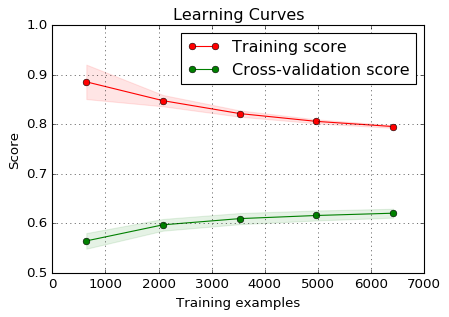

In [35]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(lg_clf, title, X, y_train, ylim=(0.5, 1.), cv=cv, n_jobs=-1)

In [36]:
def plot_ROC(model, title, xTest, yTest):
    """
    This function calculates and plots the ROC curve 
    for a test set.
    """
    
    probs = model.predict_proba(xTest)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(yTest, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 14})
    plt.grid()
    plt.title(title,fontsize=16)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt


<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

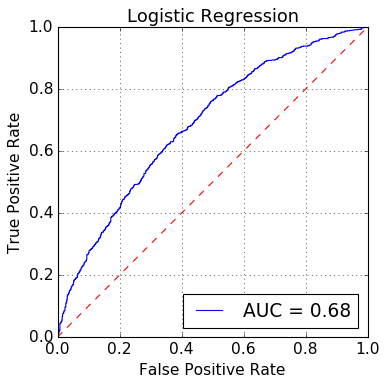

In [37]:
plot_ROC(lg_clf, "Logistic Regression", Xtest, y_test)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 20})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

Confusion matrix, without normalization
[[784 311]
 [425 485]]


<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

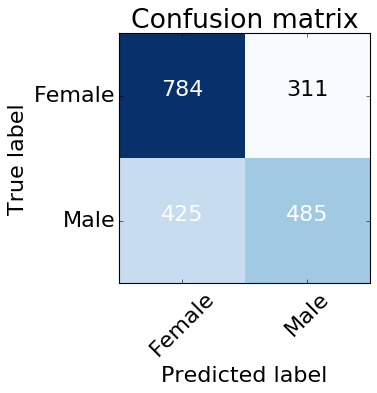

In [39]:

labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels)    
plot_confusion_matrix(cm, classes=['Female','Male'])

In [40]:
def word_cloud_generator(model, TF_model, Num_feature ):

    coef = model.coef_.ravel()
    feature_names = TF_model.get_feature_names()
    top_positive_coefficients = np.argsort(coef)[-Num_feature:]
    top_negative_coefficients = np.argsort(coef)[:Num_feature]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    cnt_pos = Counter()
    cnt_neg = Counter()
    for i in range(0,Num_feature):
        cnt_pos[feature_names[top_positive_coefficients[i]]] =coef[top_positive_coefficients[i]]*1000
        cnt_neg[feature_names[top_negative_coefficients[i]]] =coef[top_negative_coefficients[i]]*1000

    wordcloud_pos = WordCloud(background_color="black",width=800,height=600).generate_from_frequencies(cnt_pos)
    wordcloud_neg = WordCloud(background_color="white",width=800,height=600).generate_from_frequencies(cnt_neg)
    wordcloud_pos.to_file('positive.jpg')
    wordcloud_neg.to_file('negative.jpg')
    
    


word_cloud_generator(lg_clf,TF,500)

In [41]:



def getTweets(keyword):

    searchQuery = keyword
    maxTweets = 200 # maximum number of tweets to collect. 
    tweetsPerQuery = 100 # number of tweets to fetch per query
    max_id = 19999983021845213196288 # a big id that all tweets consider before this
    sinceId = None # We want to collect all possible. So set to None.
    PrmL = []
    namesL = [] # list of users' names so far
    tweetCount = 0
    while tweetCount < maxTweets:
        try:
            
            if (not sinceId):
                new_tweets = api.search(q = searchQuery,count=tweetsPerQuery,
                                        max_id=str(max_id-1),lang= 'en')
            else:
                new_tweets = api.search(q = searchQuery,count=tweetsPerQuery,
                                        max_id=str(max_id-1),since_Id=sinceId,lang= 'en')
            
            if not new_tweets:
                # there is no more tweets
                break
            for tweet in new_tweets: 
                # not consider the retweets and also tweets from same ID
                if 'retweeted_status' not in tweet._json.keys()and tweet._json['user']['screen_name'] not in namesL :
                    
                    tw = tweet._json['text']
                    user_id = tweet._json['id']
                    screenName = tweet._json['user']['screen_name']
                    name = tweet._json['user']['name']
                    namesL.append(screenName)
                    PrmL.append([tw,user_id,screenName,name])
                    tweetCount += 1
    
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            print ("ERROR :" + str(e))
            break
    tweetsDF = pd.DataFrame(PrmL,columns={'tweet','id','screen_name','name'}) 
    return tweetsDF
               

In [52]:
def genDetect(keyword,clf_model,TF,sent_analyzer):        
    
    
    kw_tweets = getTweets(keyword)
    if len(kw_tweets)> 0 : 
        kw_tweets['pol'] = kw_tweets['tweet'].apply(lambda x:sent_analyzer.polarity_scores(x)['compound'])
        kw_tweets['words'] = kw_tweets['tweet'].apply(no_of_word)


        tw_tf = TF.transform(temp['tweet'])
        tw_other = kw_tweets[['pol','words']]
        tw = sparse.hstack([tw_tf, tw_other])
        y_pred = clf_model.predict(tw)
        return [100.*float("{0:0.3f}".format(float(sum(y_pred))/len(y_pred))),len(y_pred)]
    else:
        return [0,0]
    


In [53]:
def tweet_output(keyword,clf_model,TF,sent_analyzer):
    result,num = genDetect(keyword,clf_model,TF,sent_analyzer)
    if result != 0 :            
        
        labels = ["Female", "Male"] 
        sizes = [100-result, result]
        color = ['red','blue']
        explode = (0, 0.1)  # only "explode" the 2nd slice 
        plt.rcParams.update({'font.size': 12})
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=360, colors = color)
        plt.axis('equal') 
        return plt


In [ ]:
tweet_output('Trump',lg_clf,TF,sid)